In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  # default is ‘last_expr’

%load_ext autoreload
%autoreload 2

In [20]:
import sys
sys.path.append('/Users/siyuyang/Source/Repos/GitHub_MSFT/CameraTraps')

In [64]:
import json
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

# requires the TF Object Detection API be installed
from detection.detector_eval import detector_eval  # detector_eval.py functions in this directory
from visualization import visualization_utils as viz_utils

# MegaDetector v4 experiments - evaluation

For MDv3 and MDv2 results, some locations in their training set are in this test set (MDv4 test set).

In [4]:
mdv4boxes_label_path = '/Users/siyuyang/OneDrive - Microsoft/AI4Earth/CameraTrap/Databases/query_results/bboxes_20200123.json'

res_dir = '/Users/siyuyang/Source/temp_data/CameraTrap/megadetector_v4/mdv4_results'
test_set_res_paths = {
    'mdv4_baseline_run12_step520k': '5247_detections_mdv4_baseline_run12_step520k_on_test_20200310001011.json',
    'mdv4_baseline_run5_step735902': '8542_detections_mdv4_baseline_run5_step735902_on_test_20200310014304.json',
    'mdv3': '8583_detections_mdv3_on_test_20200310002010.json',
    'mdv2': '1983_detections_mdv2_on_test_20200310004514.json'
}

out_dir = '/Users/siyuyang/OneDrive - Microsoft/AI4Earth/CameraTrap/MegaDetectorEval/megadetectorv4'

## Matching label and predicted boxes

In [5]:
test_set_res = {}
for checkpoint_name, out_name in test_set_res_paths.items():
    with open(os.path.join(res_dir, out_name)) as f:
        test_set_res[checkpoint_name] = json.load(f)['images']
    print('{}, number of results: {}'.format(checkpoint_name, len(test_set_res[checkpoint_name])))

mdv4_baseline_run12_step520k, number of results: 17023
mdv4_baseline_run5_step735902, number of results: 17023
mdv3, number of results: 17023
mdv2, number of results: 17023


In [25]:
# for numerical IDs from output files of the API, and names in the MegaDB
label_map_name_to_id = {
    'animal': 1,
    'person': 2,
    'vehicle': 3
}

In [8]:
test_set_res['mdv4_baseline_run12_step520k'][100]

{'file': 'mdv4_images/test/rspb_gola+899c8a74-3f14-11ea-b66d-9801a7a664ab.jpg',
 'max_detection_conf': 1.0,
 'detections': [{'category': '1',
   'conf': 1.0,
   'bbox': [0.0016, 0.2824, 0.2653, 0.3398]},
  {'category': '1', 'conf': 0.068, 'bbox': [0.9802, 0.4392, 0.0177, 0.0373]},
  {'category': '1', 'conf': 0.064, 'bbox': [0.9764, 0.4356, 0.0225, 0.0582]}]}

In [53]:
# not used

test_set = set([i['file'].split('/')[-1].split('.jpg')[0] for i in test_set_res['mdv4_baseline_run12_step520k']])
len(test_set)

17023

In [6]:
with open(mdv4boxes_label_path) as f:
    mdv4boxes_labels = json.load(f)

In [7]:
len(mdv4boxes_labels)
mdv4boxes_labels[100]

480000

{'bbox': [{'category': 'person', 'bbox': [0.7821, 0.6417, 0.2178, 0.3316]},
  {'category': 'person', 'bbox': [0, 0.2614, 0.2018, 0.29]}],
 'file': 'Day/2/IMAG0462 (7).JPG',
 'dataset': 'peaceparks_201908_humans',
 'location': '7',
 'download_id': 'peaceparks_201908_humans+8896d576-3f14-11ea-b3bb-9801a7a664ab'}

In [54]:
mdv4boxes_labels_dict = {}
for i in mdv4boxes_labels:
    if i['download_id'] in test_set:
        mdv4boxes_labels_dict[i['download_id']] = i
print(len(mdv4boxes_labels_dict))

17023


## Compute metrics

In [62]:
checkpoint_metrics = {}

for checkpoint_name, detection_res in test_set_res.items():
    print(checkpoint_name)
    
    per_image_gts, per_image_detections = detector_eval.get_per_image_gts_and_detections(
        mdv4boxes_labels_dict, detection_res, label_map_name_to_id)
        
    print('Lengths of per_image_gts is {}, per_image_detections is {}'.format(
        len(per_image_gts), len(per_image_detections)))
    
    per_cat_metrics = detector_eval.compute_precision_recall_bbox(per_image_detections, per_image_gts, 3, 
                                                    matching_iou_threshold=0.5)

    checkpoint_metrics[checkpoint_name] = per_cat_metrics
    print('one_class average precision is {}'.format(per_cat_metrics['one_class']['average_precision']))
    print('-----------')
    

mdv4_baseline_run12_step520k


  1%|          | 98/17023 [00:00<00:17, 975.37it/s]

Lengths of per_image_gts is 17023, per_image_detections is 17023
Running per-object analysis...


100%|██████████| 17023/17023 [00:12<00:00, 1358.34it/s]


Computing precision recall for each category...
Number of ground truth in category 1 is 18505
Number of ground truth in category 2 is 3185
Number of ground truth in category 3 is 60


  0%|          | 0/17023 [00:00<?, ?it/s]

one_class average precision is 0.8837287615702089
-----------
mdv4_baseline_run5_step735902
Lengths of per_image_gts is 17023, per_image_detections is 17023
Running per-object analysis...


100%|██████████| 17023/17023 [00:13<00:00, 1302.86it/s]


Computing precision recall for each category...
Number of ground truth in category 1 is 18505
Number of ground truth in category 2 is 3185
Number of ground truth in category 3 is 60
one_class average precision is 0.8776877228745031


  0%|          | 0/17023 [00:00<?, ?it/s]

-----------
mdv3
Lengths of per_image_gts is 17023, per_image_detections is 17023
Running per-object analysis...


100%|██████████| 17023/17023 [00:12<00:00, 1367.15it/s]


Computing precision recall for each category...
Number of ground truth in category 1 is 18505
Number of ground truth in category 2 is 3185
Number of ground truth in category 3 is 60


  0%|          | 0/17023 [00:00<?, ?it/s]

one_class average precision is 0.833470328917
-----------
mdv2
Lengths of per_image_gts is 17023, per_image_detections is 17023
Running per-object analysis...


100%|██████████| 17023/17023 [00:11<00:00, 1511.10it/s]


Computing precision recall for each category...
Number of ground truth in category 1 is 18505
Number of ground truth in category 2 is 3185
Number of ground truth in category 3 is 60
one_class average precision is 0.6459082089541535
-----------


## Plot precision-recall

In [67]:
categories = {
    1: 'animal',
    2: 'person',
    3: 'vehicle',
    'one_class': 'one class'
}

In [168]:
cat_to_fig = {}
for cat, cat_label in categories.items():
    fig = matplotlib.figure.Figure(figsize=(3, 3), dpi=120)
    ax = fig.add_axes((0, 0, 1, 1))
    
    for checkpoint_name, per_cat_metrics in checkpoint_metrics.items():
        _ = ax.plot(per_cat_metrics[cat]['recall'], per_cat_metrics[cat]['precision'], 
                    label=checkpoint_name,
                    linewidth=1)  
    
    _ = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=False, ncol=2)
    _, _ = ax.set_xlim(left=0.0, right=1.0)
    
    _ = ax.set_xlabel('Recall')
    _ = ax.set_ylabel('Precision')
    _ = ax.set_title('category: ' + cat_label)
    
    cat_to_fig[cat] = fig

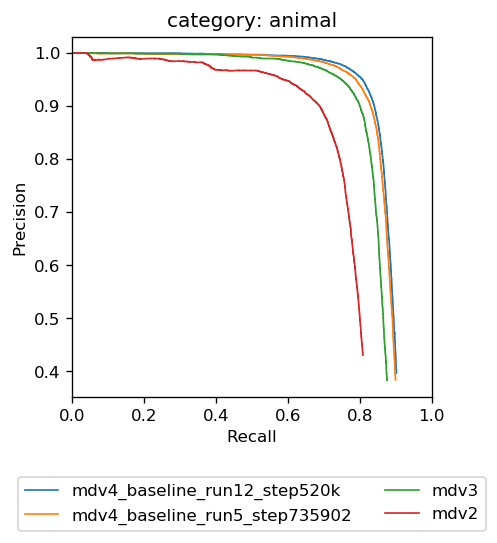

In [169]:
cat_to_fig[1]

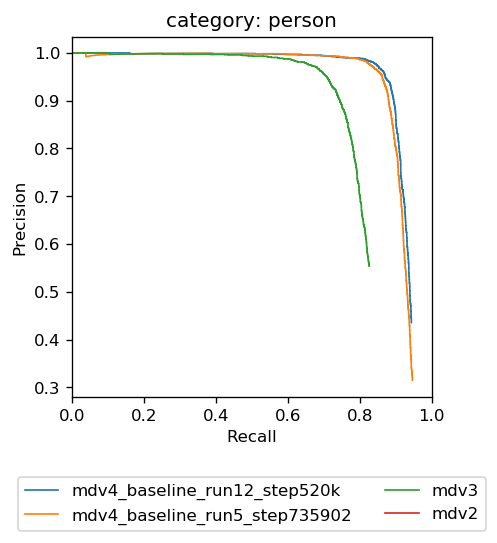

In [170]:
cat_to_fig[2]

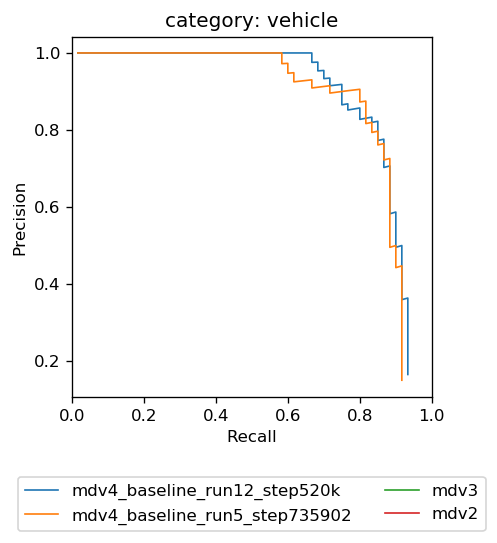

In [171]:
cat_to_fig[3]

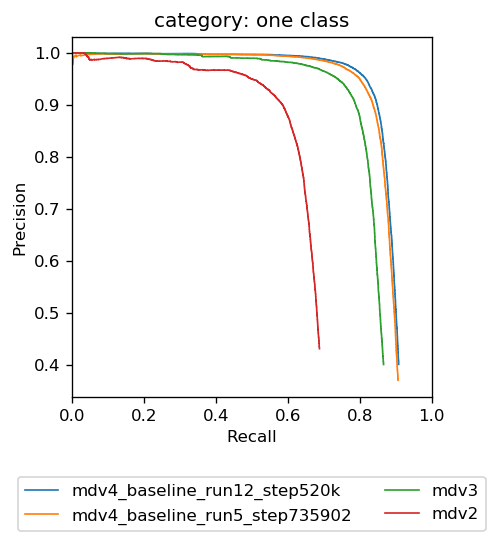

In [172]:
cat_to_fig['one_class']

## Number of true and false positives

In [175]:
for checkpoint_name, per_cat_metrics in checkpoint_metrics.items():
    print('\n{}'.format(checkpoint_name))
    for category, metrics in per_cat_metrics.items():
        print('category: {}'.format(category))
        for score_threshold in [0.5, 0.8, 0.9]:
            total_tp = 0
            total_fp = 0
            for score, tp_fp in zip(metrics['scores'], metrics['tp_fp']):
                if score > score_threshold:
                    if tp_fp == 1:
                        total_tp += 1
                    else:
                        total_fp += 1
            print('    score_threshold: {}, tp: {}, fp: {}'.format(
                score_threshold, total_tp, total_fp))


mdv4_baseline_run12_step520k
category: 1
    score_threshold: 0.5, tp: 15847, fp: 2936
    score_threshold: 0.8, tp: 15337, fp: 1310
    score_threshold: 0.9, tp: 14979, fp: 832
category: 2
    score_threshold: 0.5, tp: 2867, fp: 471
    score_threshold: 0.8, tp: 2800, fp: 175
    score_threshold: 0.9, tp: 2735, fp: 96
category: 3
    score_threshold: 0.5, tp: 53, fp: 38
    score_threshold: 0.8, tp: 52, fp: 16
    score_threshold: 0.9, tp: 50, fp: 10
category: one_class
    score_threshold: 0.5, tp: 18767, fp: 3445
    score_threshold: 0.8, tp: 18189, fp: 1501
    score_threshold: 0.9, tp: 17764, fp: 938

mdv4_baseline_run5_step735902
category: 1
    score_threshold: 0.5, tp: 15734, fp: 2985
    score_threshold: 0.8, tp: 15113, fp: 1325
    score_threshold: 0.9, tp: 14678, fp: 844
category: 2
    score_threshold: 0.5, tp: 2864, fp: 697
    score_threshold: 0.8, tp: 2783, fp: 227
    score_threshold: 0.9, tp: 2727, fp: 122
category: 3
    score_threshold: 0.5, tp: 53, fp: 52
    score

## Visualize their results